# Statistical Analysis using Kaggle ML & DS Survey Data
## Author: Yonghao Li

In [ ]:
# Load necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter
import seaborn as sns
import copy
import math
import sklearn
import scipy.stats as stats

In [ ]:
df = pd.read_csv("clean_kaggle_data.csv")
df.head()

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (207) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,Unnamed: 0,Time from Start to Finish (seconds),Q1,Q2,Q3,Q4,Q5,Q6,Q7_Part_1,Q7_Part_2,Q7_Part_3,Q7_Part_4,Q7_Part_5,Q7_Part_6,Q7_Part_7,Q7_Part_8,Q7_Part_9,Q7_Part_10,Q7_Part_11,Q7_Part_12,Q7_OTHER,Q8,Q9_Part_1,Q9_Part_2,Q9_Part_3,Q9_Part_4,Q9_Part_5,Q9_Part_6,Q9_Part_7,Q9_Part_8,Q9_Part_9,Q9_Part_10,Q9_Part_11,Q9_OTHER,Q10_Part_1,Q10_Part_2,Q10_Part_3,Q10_Part_4,Q10_Part_5,Q10_Part_6,...,Q31_B_Part_7,Q31_B_Part_8,Q31_B_Part_9,Q31_B_Part_10,Q31_B_Part_11,Q31_B_Part_12,Q31_B_Part_13,Q31_B_Part_14,Q31_B_OTHER,Q33_B_Part_1,Q33_B_Part_2,Q33_B_Part_3,Q33_B_Part_4,Q33_B_Part_5,Q33_B_Part_6,Q33_B_Part_7,Q33_B_OTHER,Q34_B_Part_1,Q34_B_Part_2,Q34_B_Part_3,Q34_B_Part_4,Q34_B_Part_5,Q34_B_Part_6,Q34_B_Part_7,Q34_B_Part_8,Q34_B_Part_9,Q34_B_Part_10,Q34_B_Part_11,Q34_B_OTHER,Q35_B_Part_1,Q35_B_Part_2,Q35_B_Part_3,Q35_B_Part_4,Q35_B_Part_5,Q35_B_Part_6,Q35_B_Part_7,Q35_B_Part_8,Q35_B_Part_9,Q35_B_Part_10,Q35_B_OTHER
0,1,289287,30-34,Man,United States of America,Master’s degree,Data Engineer,5-10 years,Python,R,SQL,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Python,NaN,NaN,Visual Studio,NaN,PyCharm,NaN,NaN,Sublime Text,NaN,NaN,NaN,NaN,NaN,Colab Notebooks,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,860,35-39,Man,Argentina,Bachelor’s degree,Software Engineer,10-20 years,NaN,NaN,NaN,NaN,NaN,Java,Javascript,NaN,NaN,Bash,NaN,NaN,NaN,R,NaN,NaN,NaN,Visual Studio Code (VSCode),NaN,NaN,Notepad++,Sublime Text,Vim / Emacs,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,NaN
2,3,507,30-34,Man,United States of America,Master’s degree,Data Scientist,5-10 years,Python,NaN,SQL,NaN,NaN,NaN,NaN,NaN,NaN,Bash,NaN,NaN,NaN,Python,NaN,NaN,NaN,NaN,PyCharm,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,8,762,35-39,Man,Germany,Doctoral degree,Data Scientist,5-10 years,Python,NaN,SQL,NaN,NaN,NaN,NaN,NaN,NaN,Bash,NaN,NaN,NaN,Python,"Jupyter (JupyterLab, Jupyter Notebooks, etc)",NaN,NaN,NaN,PyCharm,NaN,NaN,Sublime Text,Vim / Emacs,NaN,NaN,NaN,Kaggle Notebooks,Colab Notebooks,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,11,742,35-39,Man,United States of America,Doctoral degree,Research Scientist,1-2 years,NaN,R,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,R,NaN,RStudio,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
# Drop the first column with IDs
df = df.drop(df.columns[0], axis=1)
df = df.iloc[1:].reset_index()

In [ ]:
# Rename relevant columns
df_clean = df.rename(columns={'Q1': 'Age', 'Q2': 'Gender', 'Q3': 'Country', 'Q4': 'Education',
                              'Q5': 'Profession', 'Q6': 'Years_of_Experience', 'Q8': 'Main_Language',
                              'Q20': 'Company_Size', 'Q24': 'Salary'})
df_clean = df_clean[['Age', 'Gender', 'Country', 'Education', 'Profession',
                     'Years_of_Experience', 'Main_Language', 'Company_Size',
                     'Salary']]
df_clean.head()

,Age,Gender,Country,Education,Profession,Years_of_Experience,Main_Language,Company_Size,Salary
0,35-39,Man,Argentina,Bachelor’s degree,Software Engineer,10-20 years,R,"1000-9,999 employees",20000
1,30-34,Man,United States of America,Master’s degree,Data Scientist,5-10 years,Python,250-999 employees,150000
2,35-39,Man,Germany,Doctoral degree,Data Scientist,5-10 years,Python,"1000-9,999 employees",80000
3,35-39,Man,United States of America,Doctoral degree,Research Scientist,1-2 years,R,0-49 employees,40000
4,30-34,Man,Canada,Bachelor’s degree,Data Engineer,< 1 years,Python,0-49 employees,100000


## 1. EDA

In [ ]:
df_clean[df_clean.isnull().any(axis=1)]

,Age,Gender,Country,Education,Profession,Years_of_Experience,Main_Language,Company_Size,Salary
15,50-54,Woman,United States of America,Bachelor’s degree,Other,I have never written code,NaN,"1000-9,999 employees",150000
16,35-39,Man,India,Bachelor’s degree,Other,I have never written code,NaN,"10,000 or more employees",20000
27,35-39,Man,Saudi Arabia,Bachelor’s degree,Other,I have never written code,NaN,"1000-9,999 employees",50000
85,22-24,Woman,India,Bachelor’s degree,Software Engineer,I have never written code,NaN,"10,000 or more employees",1000
124,22-24,Man,India,Bachelor’s degree,Software Engineer,I have never written code,NaN,"10,000 or more employees",3000
...,...,...,...,...,...,...,...,...,...
10657,35-39,Man,Other,Some college/university study without earning ...,Machine Learning Engineer,I have never written code,NaN,0-49 employees,2000
10661,35-39,Man,India,Doctoral degree,Other,I have never written code,NaN,50-249 employees,1000
10673,30-34,Man,Italy,Doctoral degree,Business Analyst,I have never written code,NaN,"1000-9,999 employees",125000
10687,40-44,Man,Argentina,Professional degree,Other,I have never written code,NaN,"10,000 or more employees",2000


In [ ]:
# Replace NaN values in 'Main Language' column with 'None'
values = {'Main_Language': 'None'}
df_clean.fillna(value=values, inplace=True)

# Replace long strings
df_clean.loc[df_clean['Education'] == "Some college/university study without earning a bachelor's degree", 'Education'] = 'Some College'
df_clean.loc[df_clean['Education'] == 'Some college/university study without earning a bachelor’s degree', 'Education'] = 'Some College'

In [ ]:
# Create pivot table DF for salary and age
age_vs_sal = pd.DataFrame(df_clean.pivot_table(values='Salary', index='Age', aggfunc=np.mean))
age_vs_sal = age_vs_sal.sort_values(by='Age')
age_vs_sal.reset_index(inplace=True)

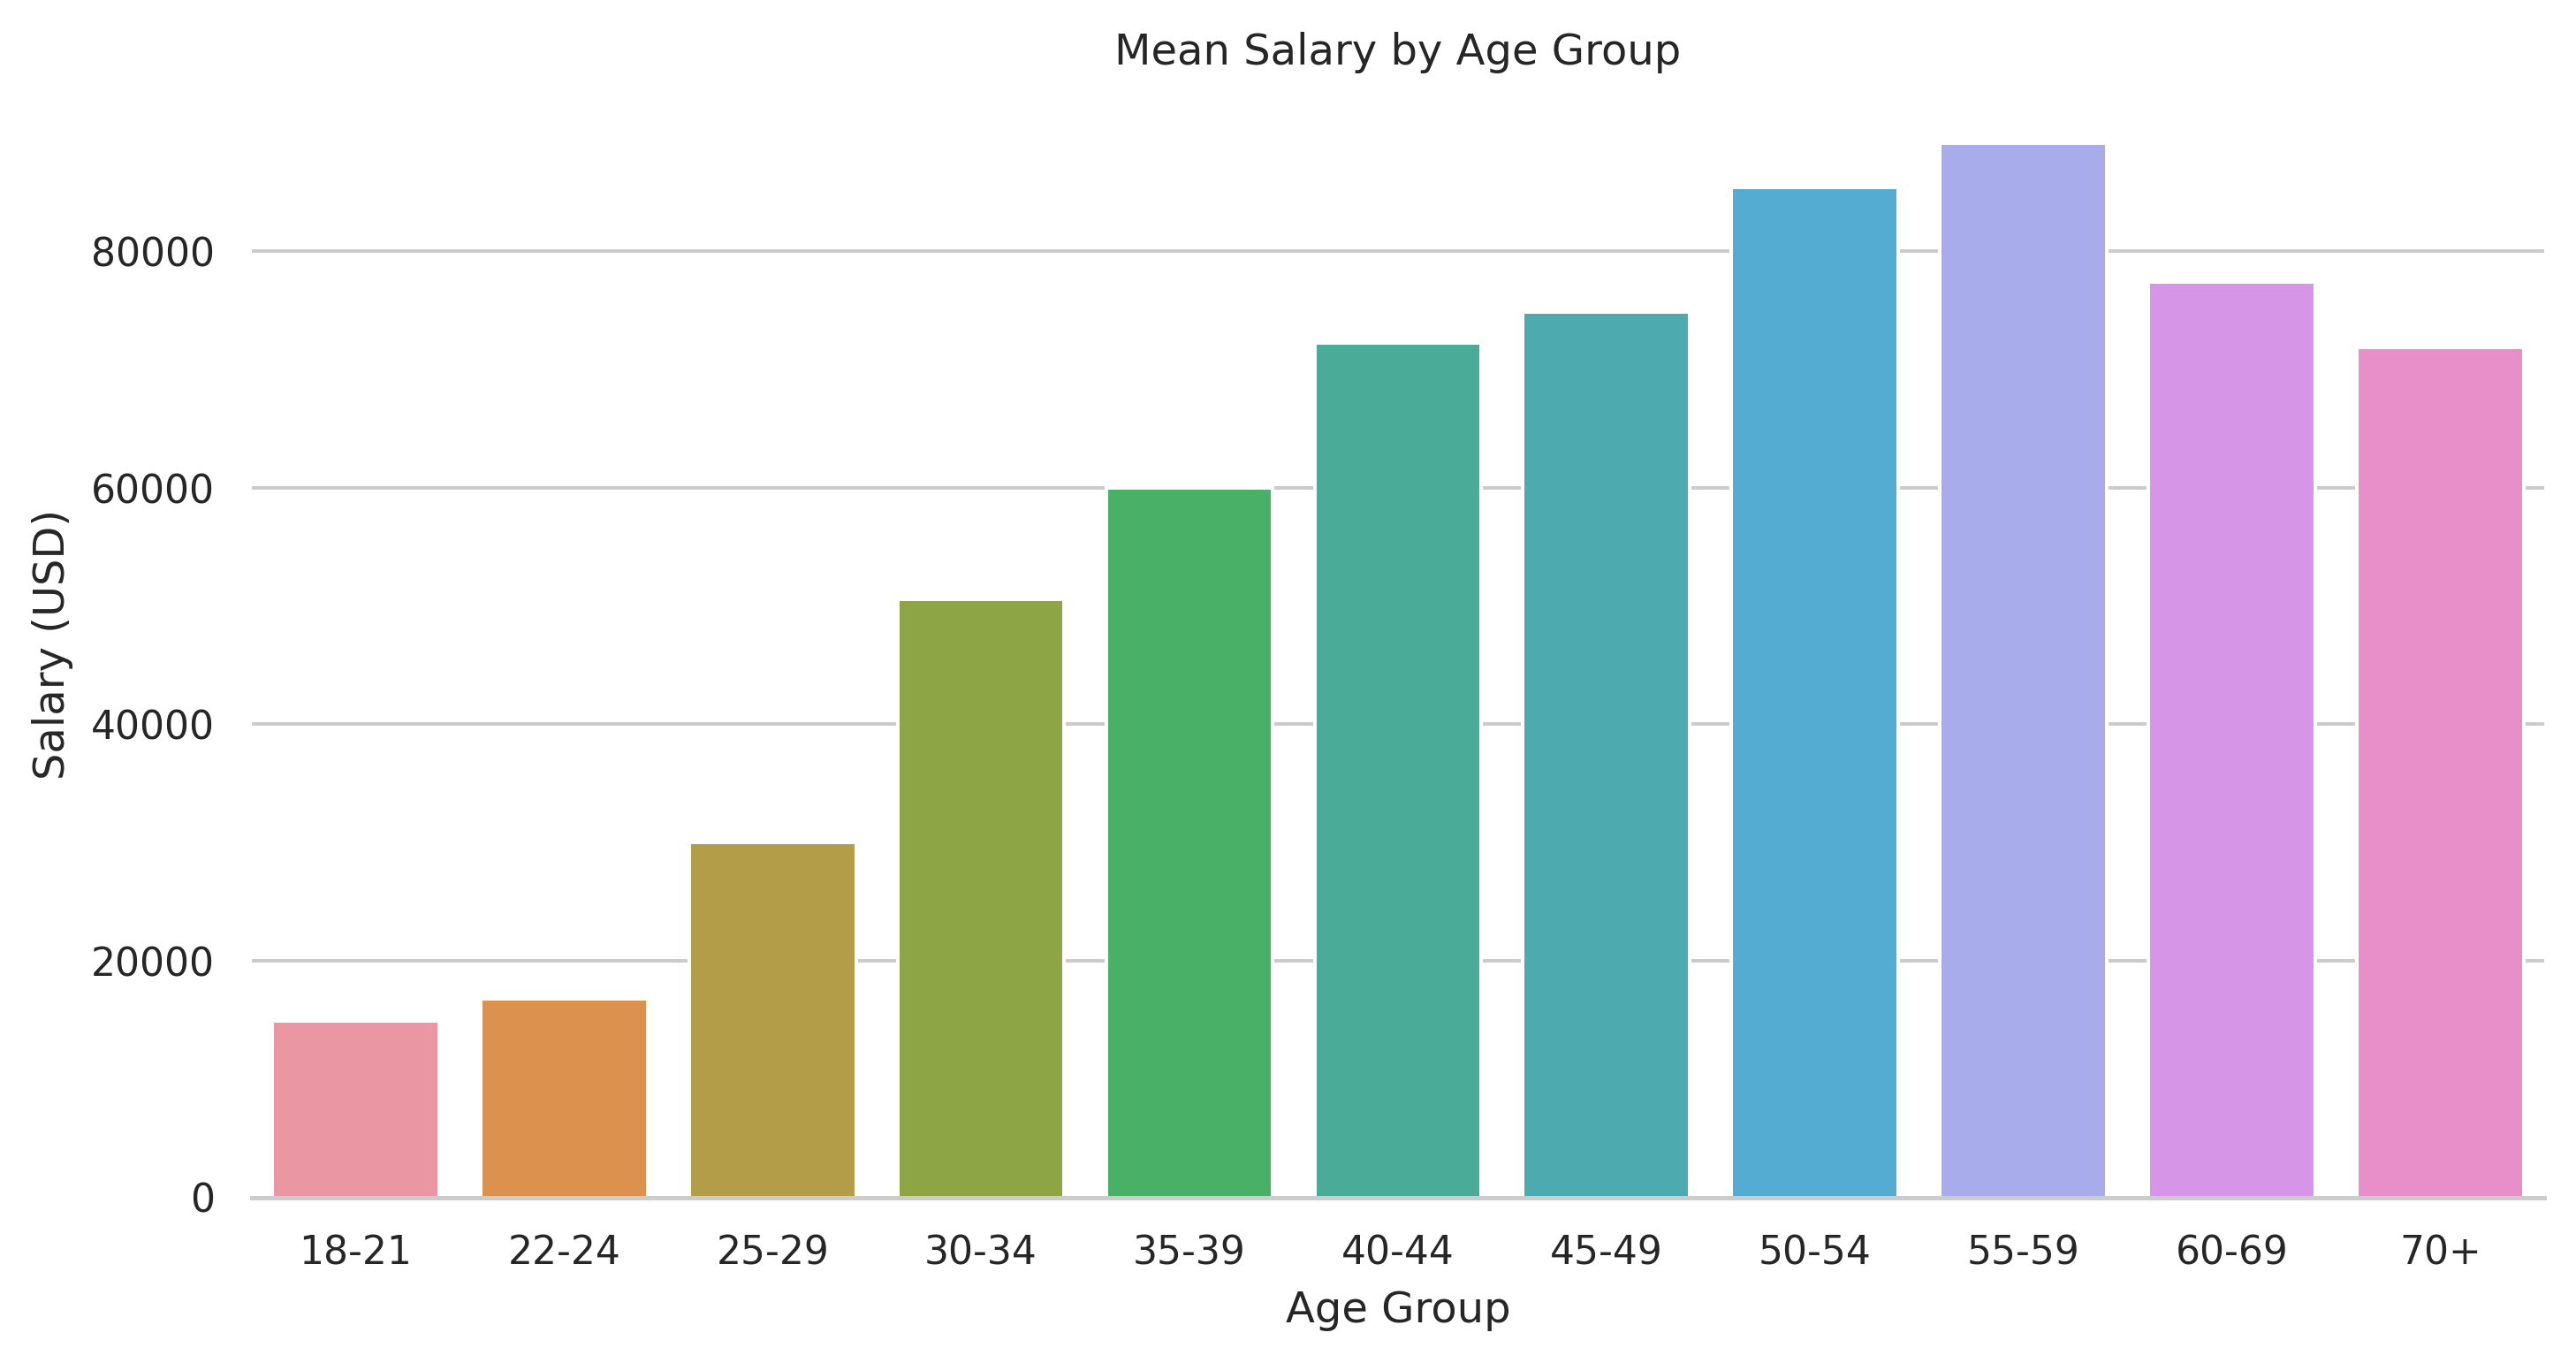

In [ ]:
# Salary vs Age
sns.set_theme(style="whitegrid")
sns.set_context("paper")
plt.rcParams['figure.dpi'] = 360
ax = sns.catplot(x='Age',y='Salary',data=age_vs_sal, kind='bar', height=4, aspect=2)
ax.set(xlabel='Age Group', ylabel='Salary (USD)', title='Mean Salary by Age Group')
sns.despine(left=True)

In the salary vs. age plot, we can see that the average salary increases as age increases, peaks around age 50-60, then slowly decreases.

In [ ]:
# Create pivot table DF for salary and country
country_vs_sal = pd.DataFrame(df_clean.pivot_table(values='Salary', index='Country', aggfunc=np.mean))
country_vs_sal = country_vs_sal.sort_values(by='Salary', ascending=False).head(10) # only get the top ten countries
country_vs_sal.reset_index(inplace=True)

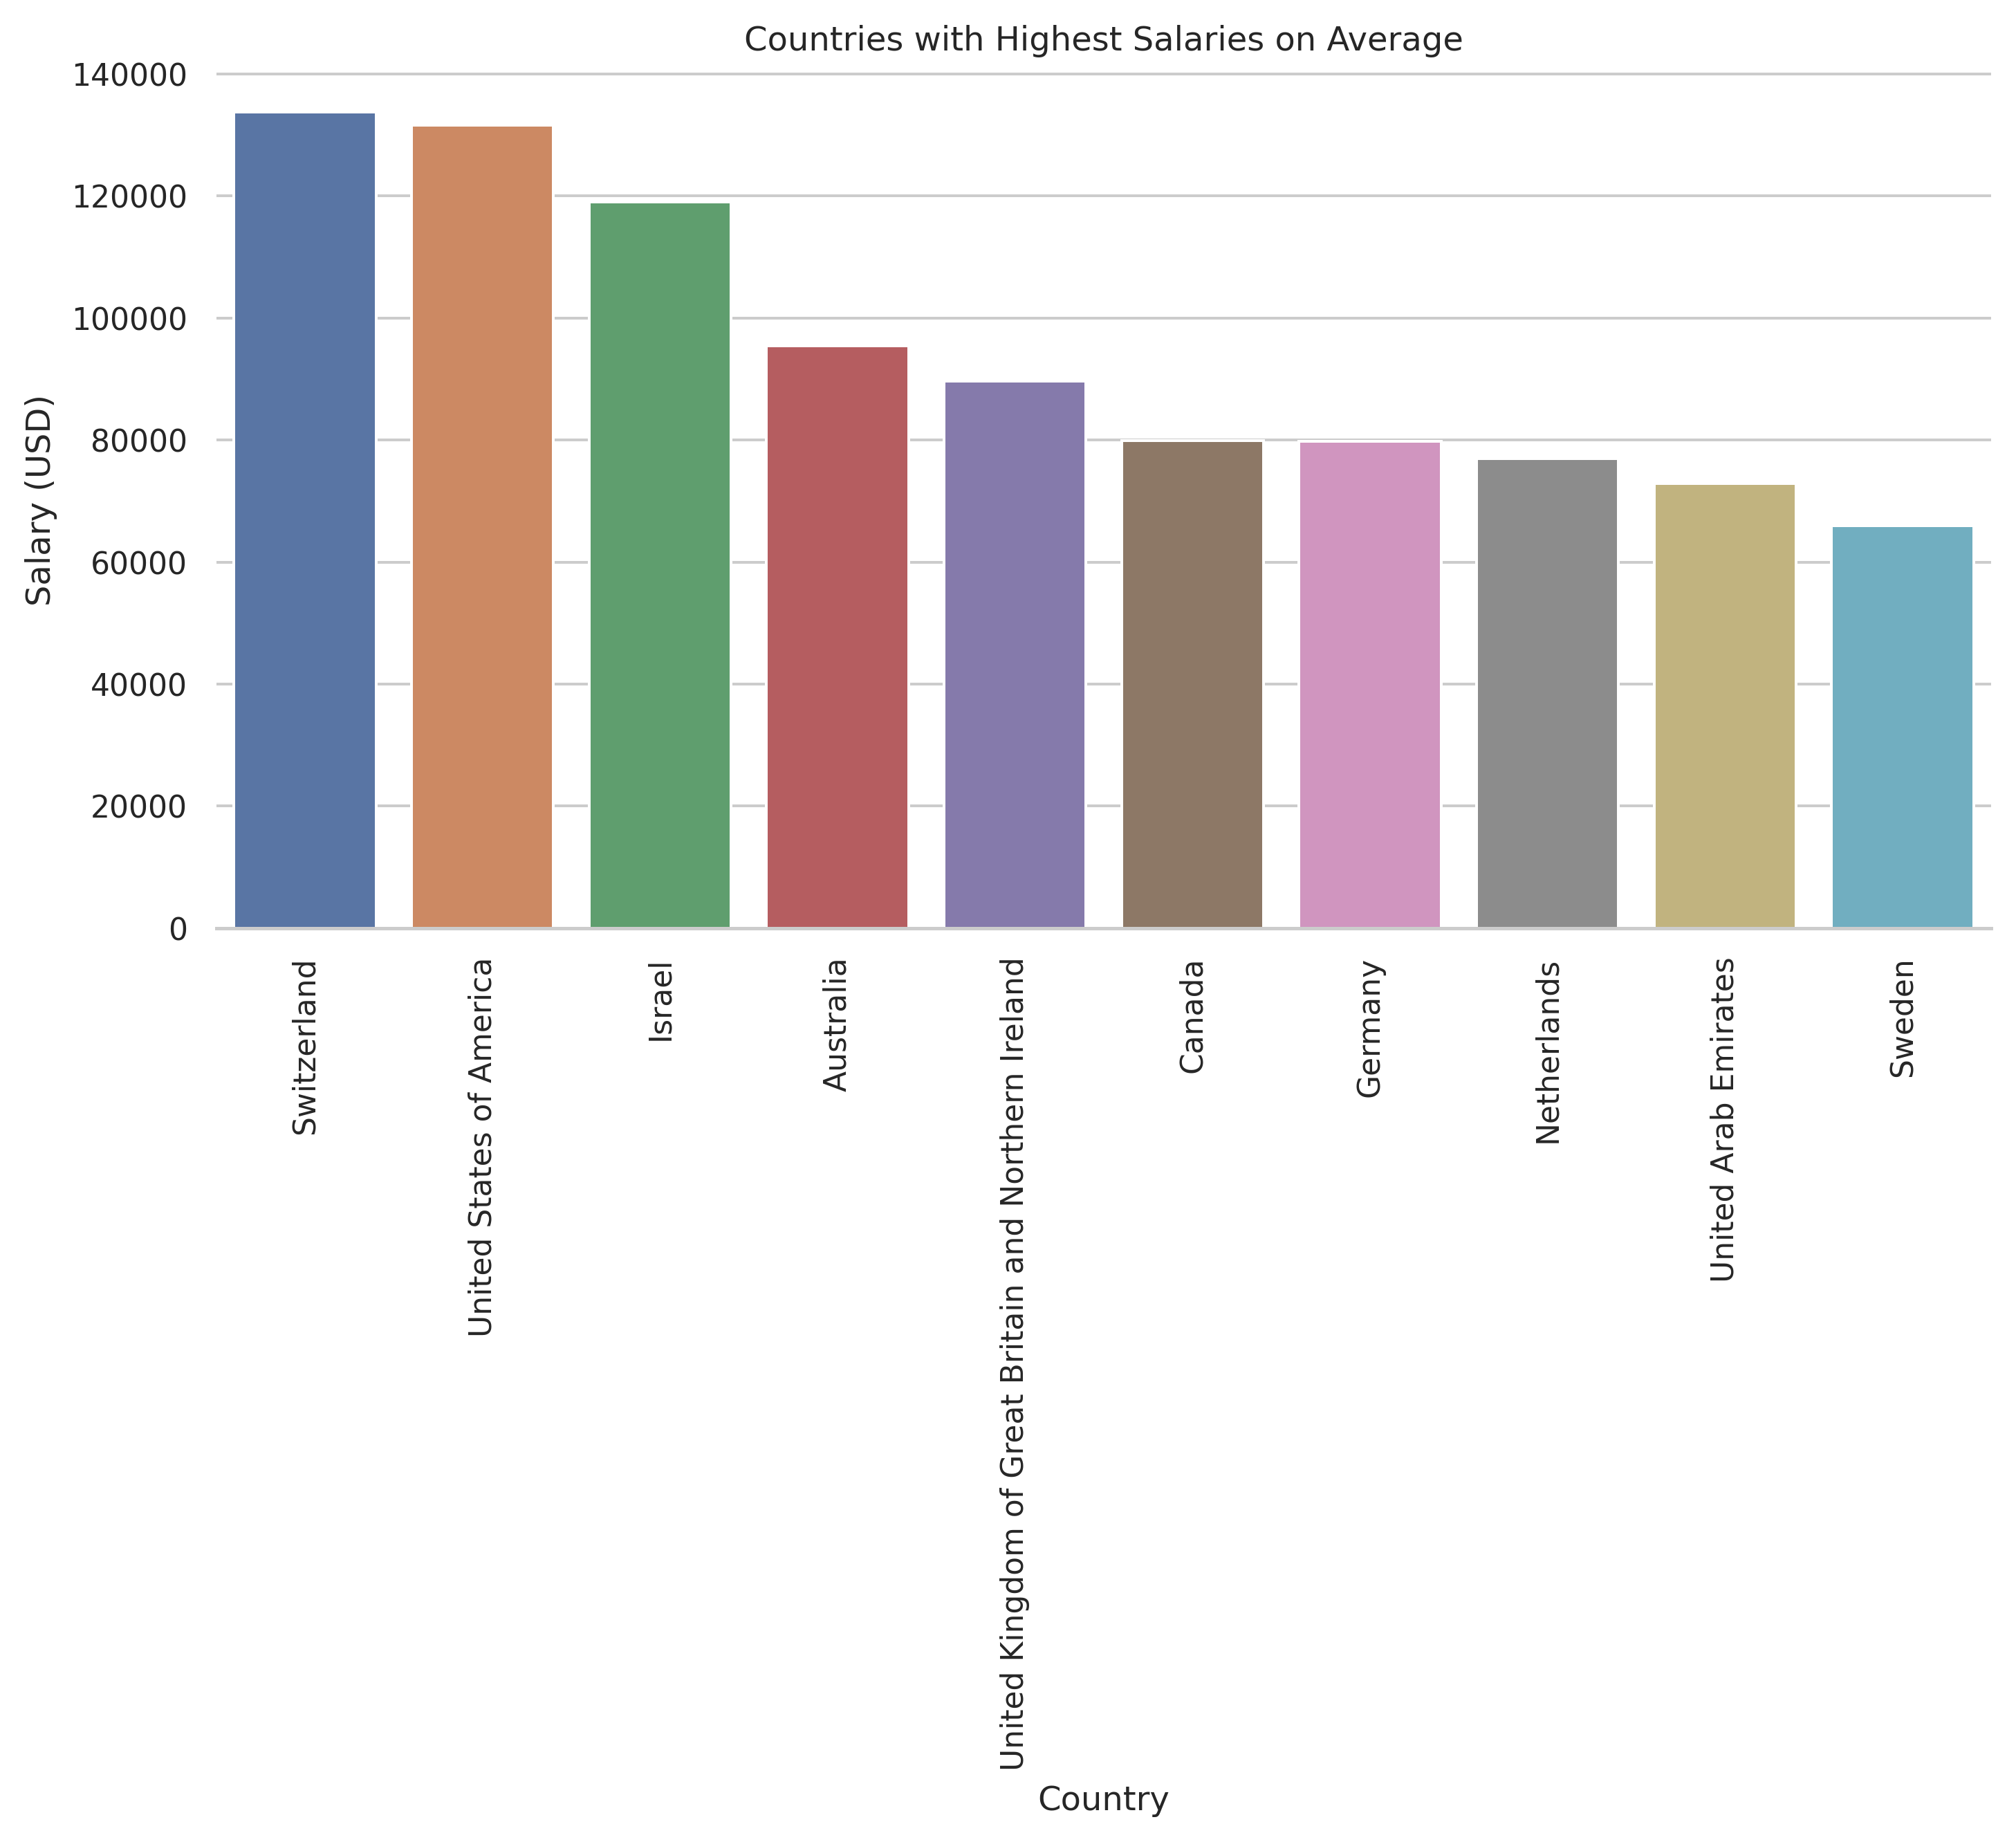

In [ ]:
# Salary vs Country
sns.set_theme(style="whitegrid")
sns.set_context("paper")
plt.rcParams['figure.dpi'] = 360
ax2 = sns.catplot(x='Country',y='Salary',data=country_vs_sal, kind='bar', height=4, aspect=2)
ax2.set(xlabel='Country', ylabel='Salary (USD)', title='Countries with Highest Salaries on Average')
plt.xticks(rotation=90)
sns.despine(left=True)

From this plot we can see that Switzerland, USA, and Israel are the top three countries with the highest mean salary levels in this dataset.

In [ ]:
# Create pivot table DF for salary and education
edu_vs_sal = pd.DataFrame(df_clean.pivot_table(values='Salary', index='Education', aggfunc=np.mean))
edu_vs_sal = edu_vs_sal.sort_values(by='Salary', ascending=False).head(7)
edu_vs_sal.reset_index(inplace=True)

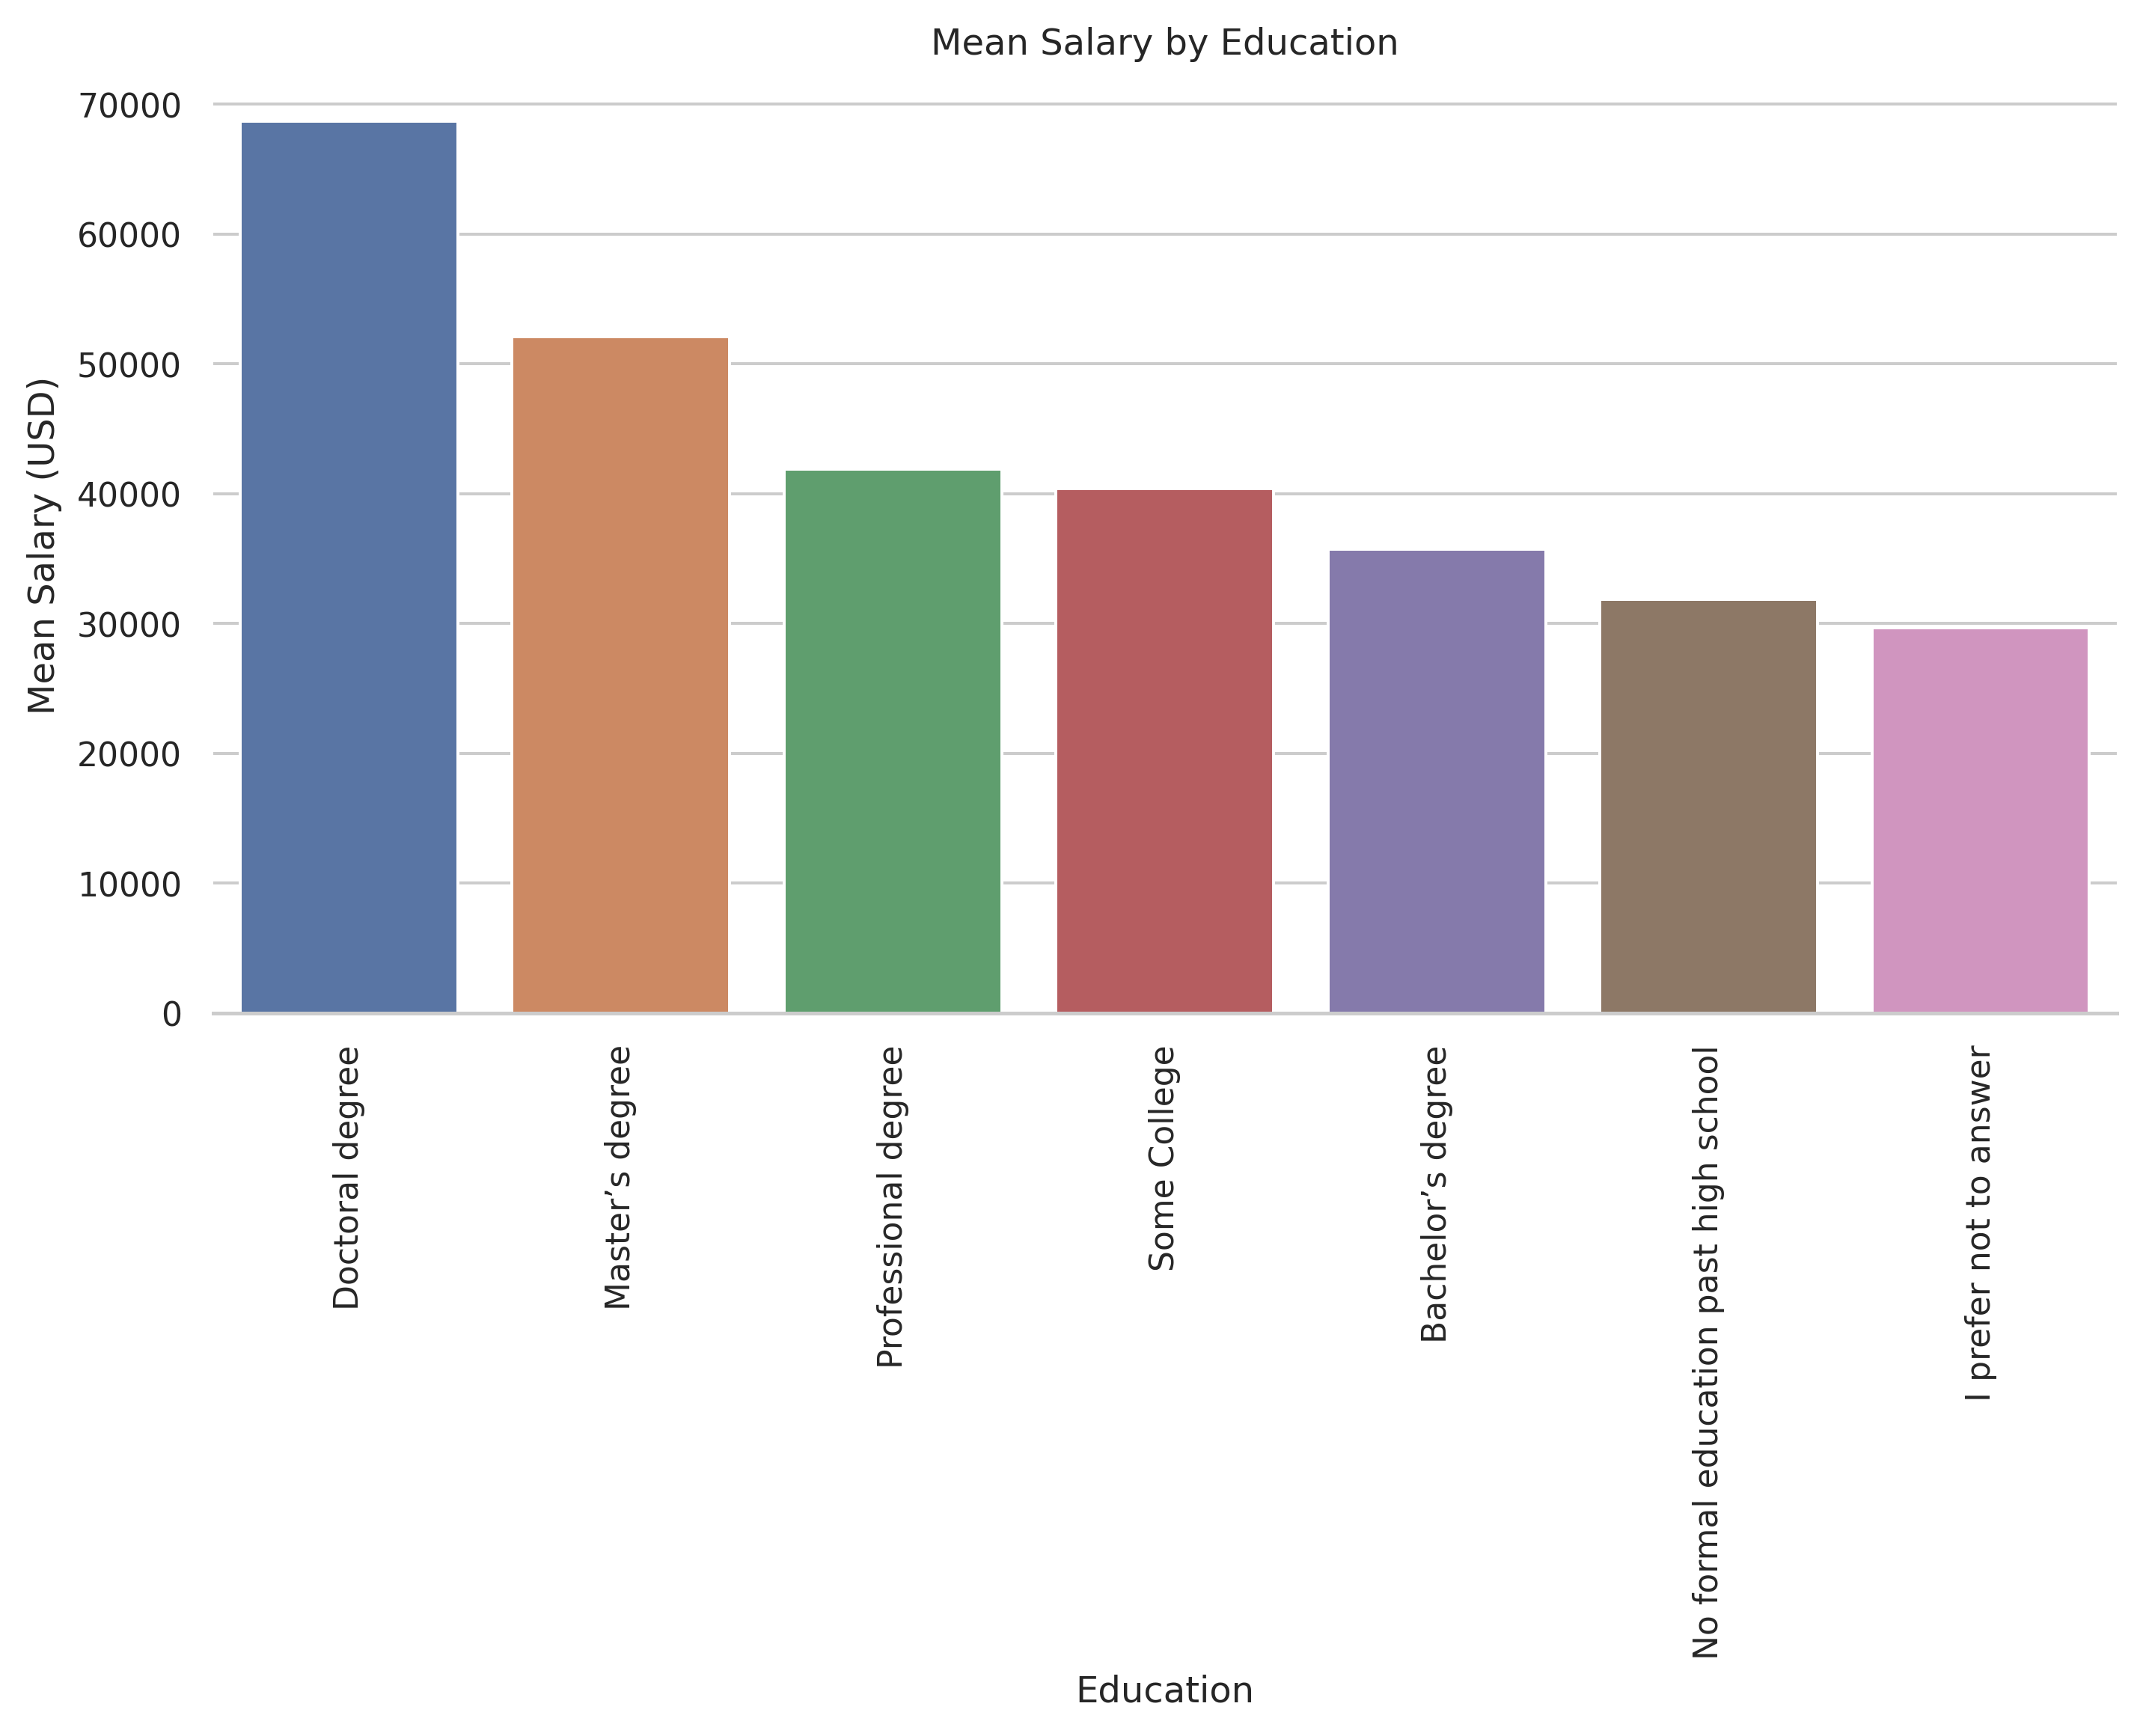

In [ ]:
# Salary vs Education
sns.set_theme(style="whitegrid")
sns.set_context("paper")
plt.rcParams['figure.dpi'] = 360
ax3 = sns.catplot(x='Education', y='Salary', data=edu_vs_sal, kind='bar', height=4, aspect=2)
ax3.set(xlabel='Education', ylabel='Mean Salary (USD)', title='Mean Salary by Education')
plt.xticks(rotation=90)
sns.despine(left=True)

From this plot we can see that participants with higher education levels such as Doctoral degree and Master's degree reported much higher salaries on average.

## 2. Estimating the difference between average salary (Q24) of men vs. women (Q2) participants

### 2a. Compute and report descriptive statistics for each

In [ ]:
# Create salary dataframes for two gender groups
man = df_clean['Gender'] == 'Man'
woman = df_clean['Gender'] == 'Woman'
df_man = df_clean[man][['Salary']]
df_woman = df_clean[woman][['Salary']]

In [ ]:
# Compute descriptive statistics for salaries
data = {"Man": df_man.describe().to_numpy().flatten(), "Woman": df_woman.describe().to_numpy().flatten()}
gender_stats = pd.DataFrame(data, index=df_man.describe().index)
gender_stats

,Man,Woman
count,8871.000000,1683.000000
mean,50742.250028,36417.112299
std,70347.522274,59442.716093
min,1000.000000,1000.000000
25%,3000.000000,1000.000000
50%,25000.000000,7500.000000
75%,70000.000000,50000.000000
max,500000.000000,500000.000000


### 2b. Suitability of two-sample t-test with original data

In [ ]:
# Using the normaltest based on D'Agostino and Pearson's tests
def norm_test(dist):
    alpha = 0.05
    _, p_value = stats.normaltest(dist)
    if p_value < alpha:
        print('Reject null hypothesis, distribution is not normal.')
    else:
        print('Failed to reject null hypothesis, distribution is normal.')

In [ ]:
# Test for normality in both distributions
norm_test(df_man)
norm_test(df_woman)

Reject null hypothesis, distribution is not normal.
Reject null hypothesis, distribution is not normal.


/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


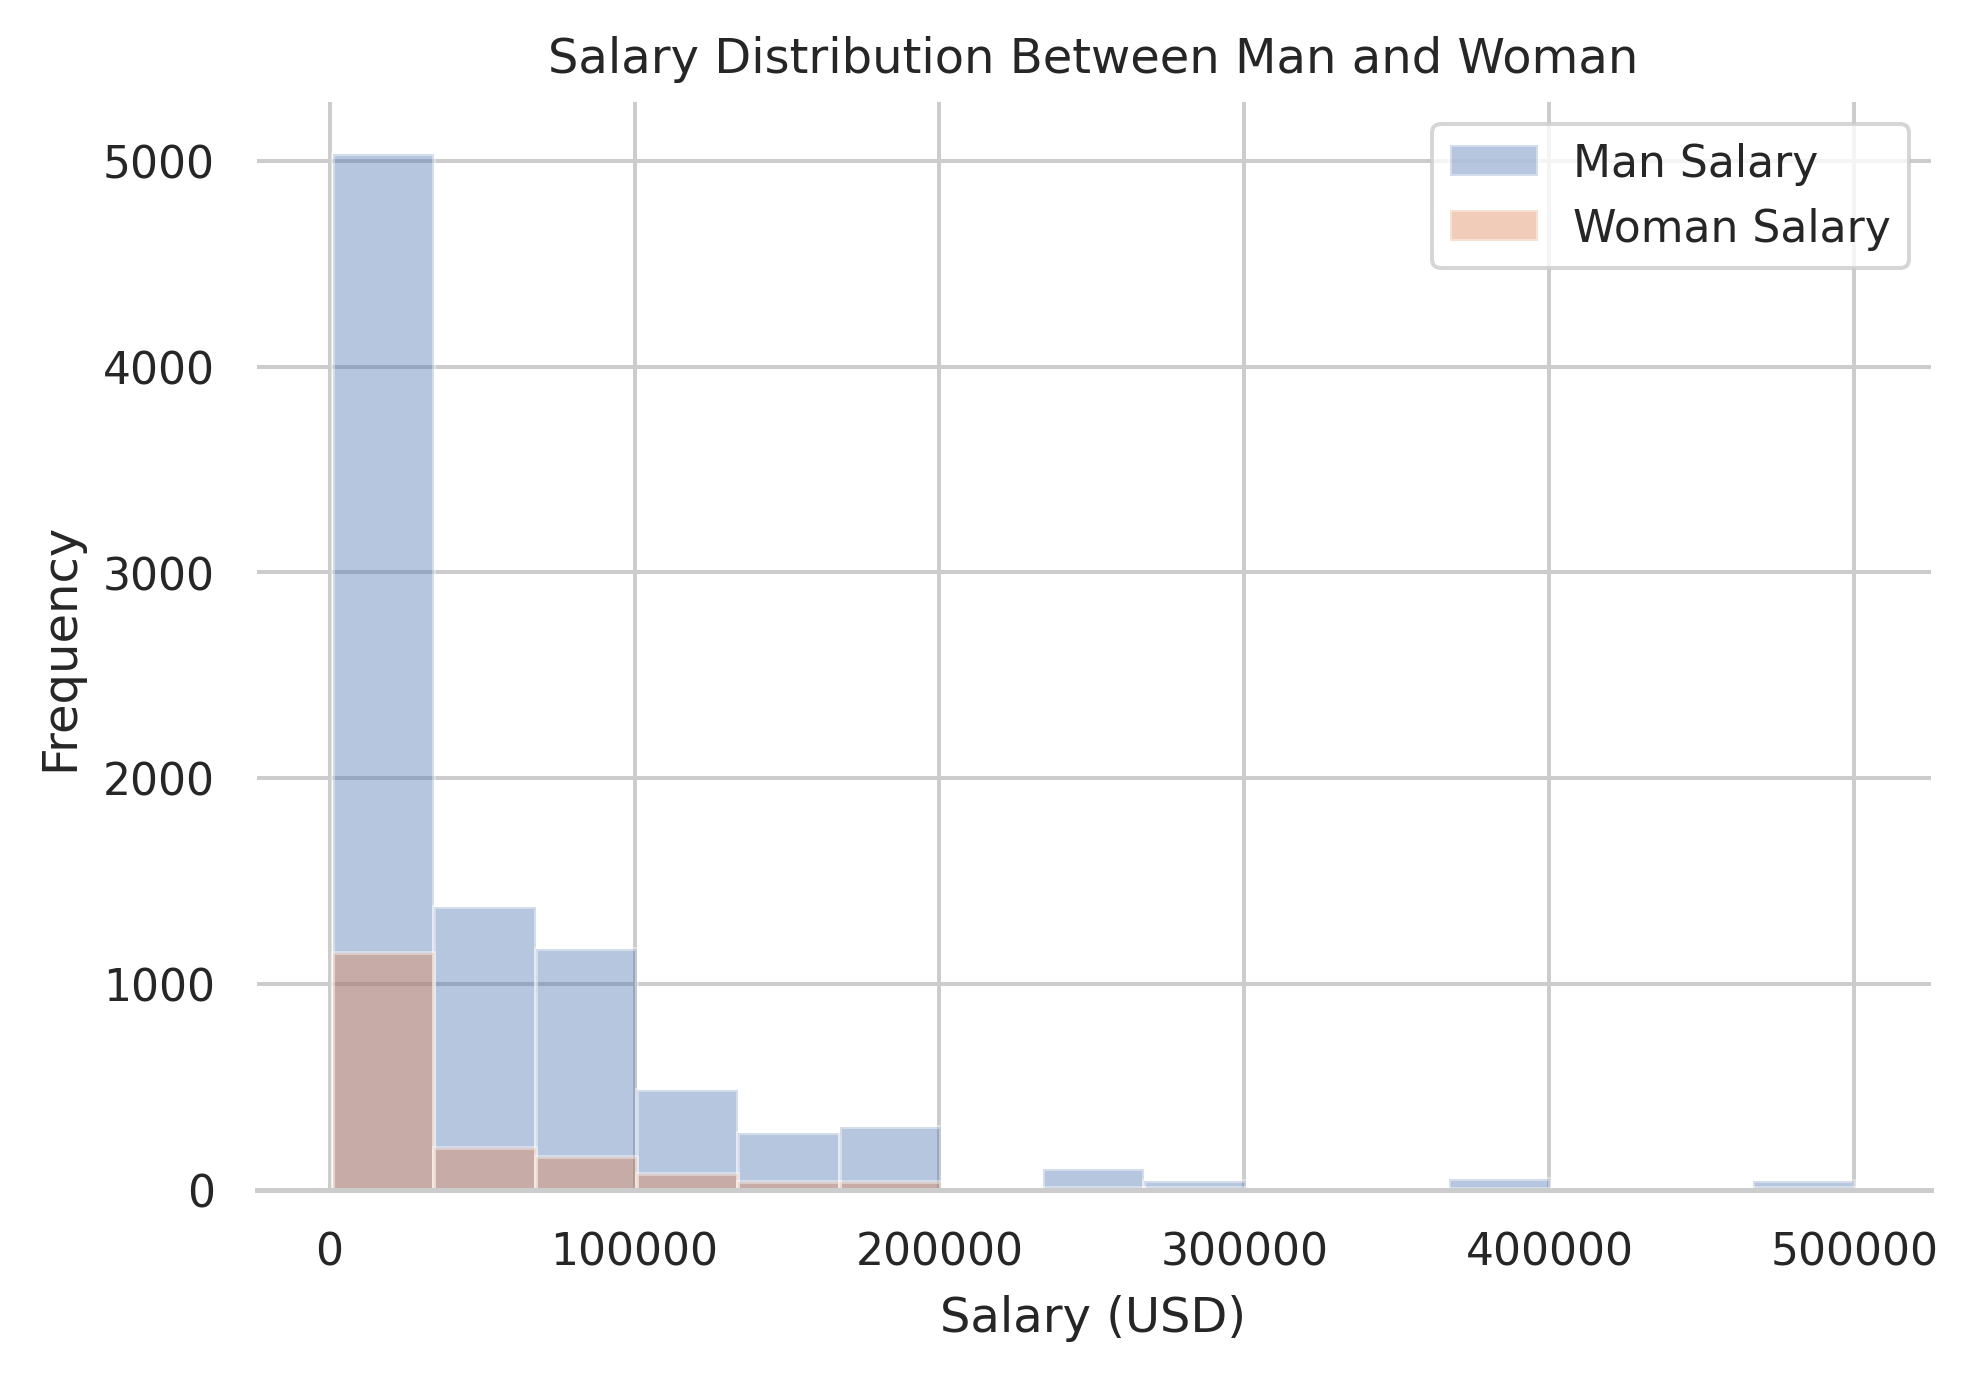

In [ ]:
# Original distributions
sns.set_theme(style="whitegrid")
sns.set_context("paper")
plt.rcParams['figure.dpi'] = 360
fig, ax = plt.subplots()
for a in [df_man.Salary, df_woman.Salary]:
    sns.distplot(a, bins=15, ax=ax, kde=False)
ax.set(xlabel='Salary (USD)', ylabel='Frequency', title='Salary Distribution Between Man and Woman')
plt.legend(labels=['Man Salary','Woman Salary'])
sns.despine(left=True)

Based on the normality tests and the distribution plots above, we can tell that the original data for the two gender groups do not follow a normal distribution. The normality assumption is not met using the original data.

In [ ]:
# Levene's test for homoscedasticity
def levene_test(dist1, dist2):
    alpha = 0.05
    _, p_value = stats.levene(dist1, dist2, center='mean')
    if p_value < alpha:
        print('Statistically significant, the groups have different variances.')
    else:
        print('Failed to reject null hypothesis, the groups have similar variances.')

In [ ]:
# Use Levene's test for the two gender populations
levene_test(df_man.Salary, df_woman.Salary)

Statistically significant, the groups have different variances.


Using the Levene's test for homogeneity of variances, we can see that the two gender groups have different variances. Thus, the original data does not satisfy the equal variance assumption.

Although the two gender groups are independent of each other, the original data does not satisfy either the normality assumption or the equal variances assumption. Thus, the original data is not suitable for two-sample t-test.

### 2c. Bootstrapping for comparing difference in means of two gender group

In [ ]:
# Bootstrapping function
def bootstrap(population_dist1, population_dist2):
    bootstrap_mean1 = []
    bootstrap_mean2 = []
    mean_diff = []

    # 1000 replications with replacement
    for i in range(1000):
        # Bootstrap sampling with same size as the original distribution
        sample_mean1 = population_dist1.sample(frac=1, replace=True)
        sample_mean2 = population_dist2.sample(frac=1, replace=True)
        # Compute mean of each bootstrap sample
        bootstrap_mean1.append(sample_mean1.mean())
        bootstrap_mean2.append(sample_mean2.mean())
    
    bootstrap_mean1 = np.asarray(bootstrap_mean1).flatten()
    bootstrap_mean2 = np.asarray(bootstrap_mean2).flatten()

    # Compute difference in means
    mean_diff = bootstrap_mean1 - bootstrap_mean2

    return bootstrap_mean1, bootstrap_mean2, mean_diff

In [ ]:
# Bootstrapping and compute difference in means
bs_man, bs_woman, gender_diff = bootstrap(df_man, df_woman)

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


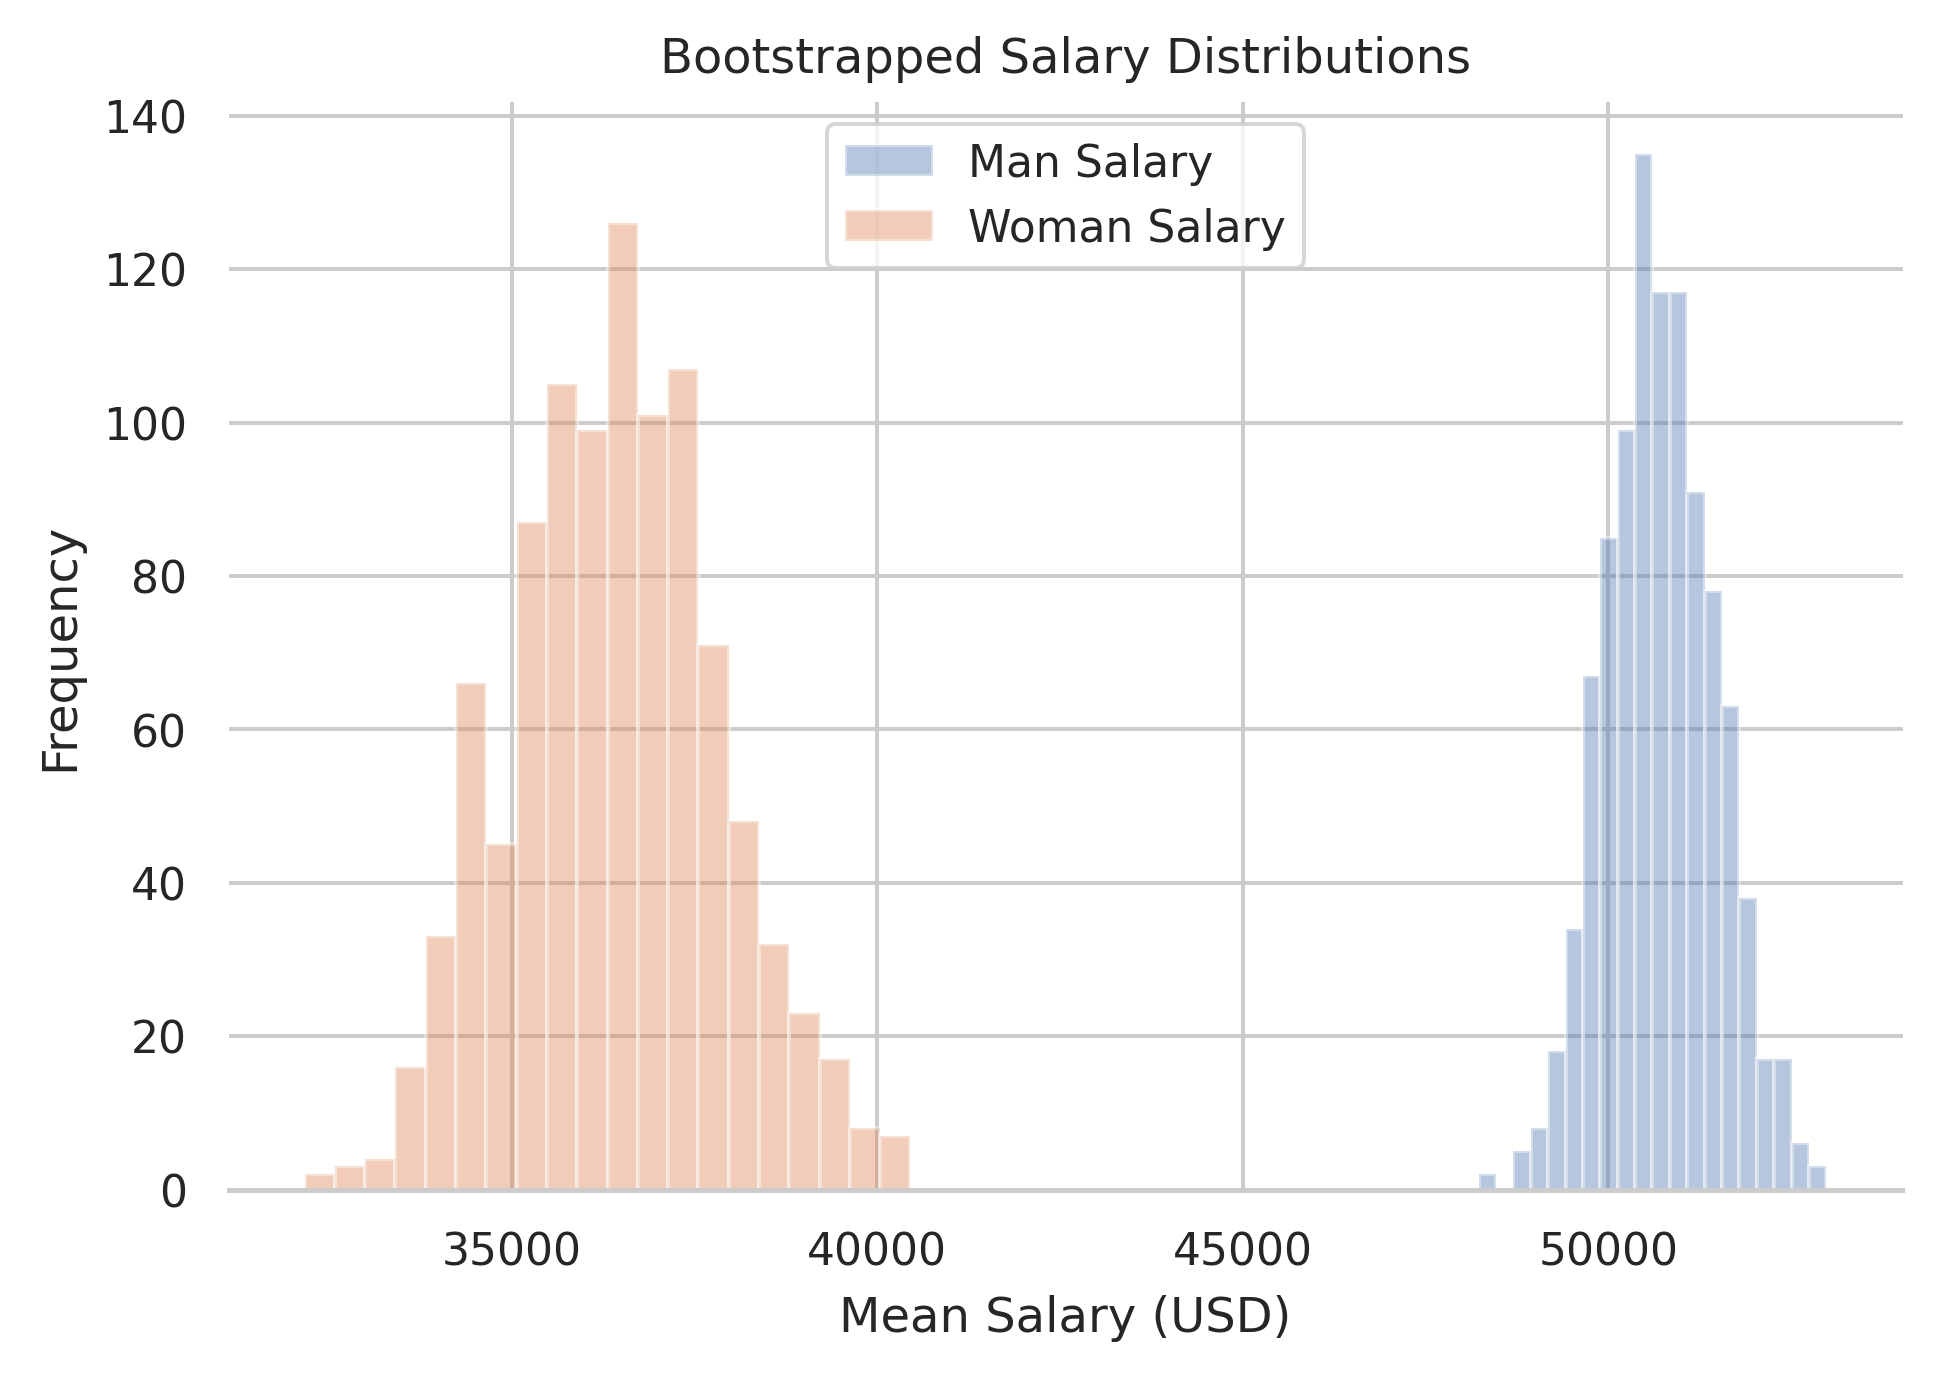

In [ ]:
# Salary distributions after bootstrapping
sns.set_theme(style="whitegrid")
sns.set_context("paper")
plt.rcParams['figure.dpi'] = 360
fig, ax = plt.subplots()
for a in [bs_man, bs_woman]:
    sns.distplot(a, bins=20, ax=ax, kde=False)
ax.set(xlabel='Mean Salary (USD)', ylabel='Frequency', title='Bootstrapped Salary Distributions')
plt.legend(labels=['Man Salary','Woman Salary'])
sns.despine(left=True)

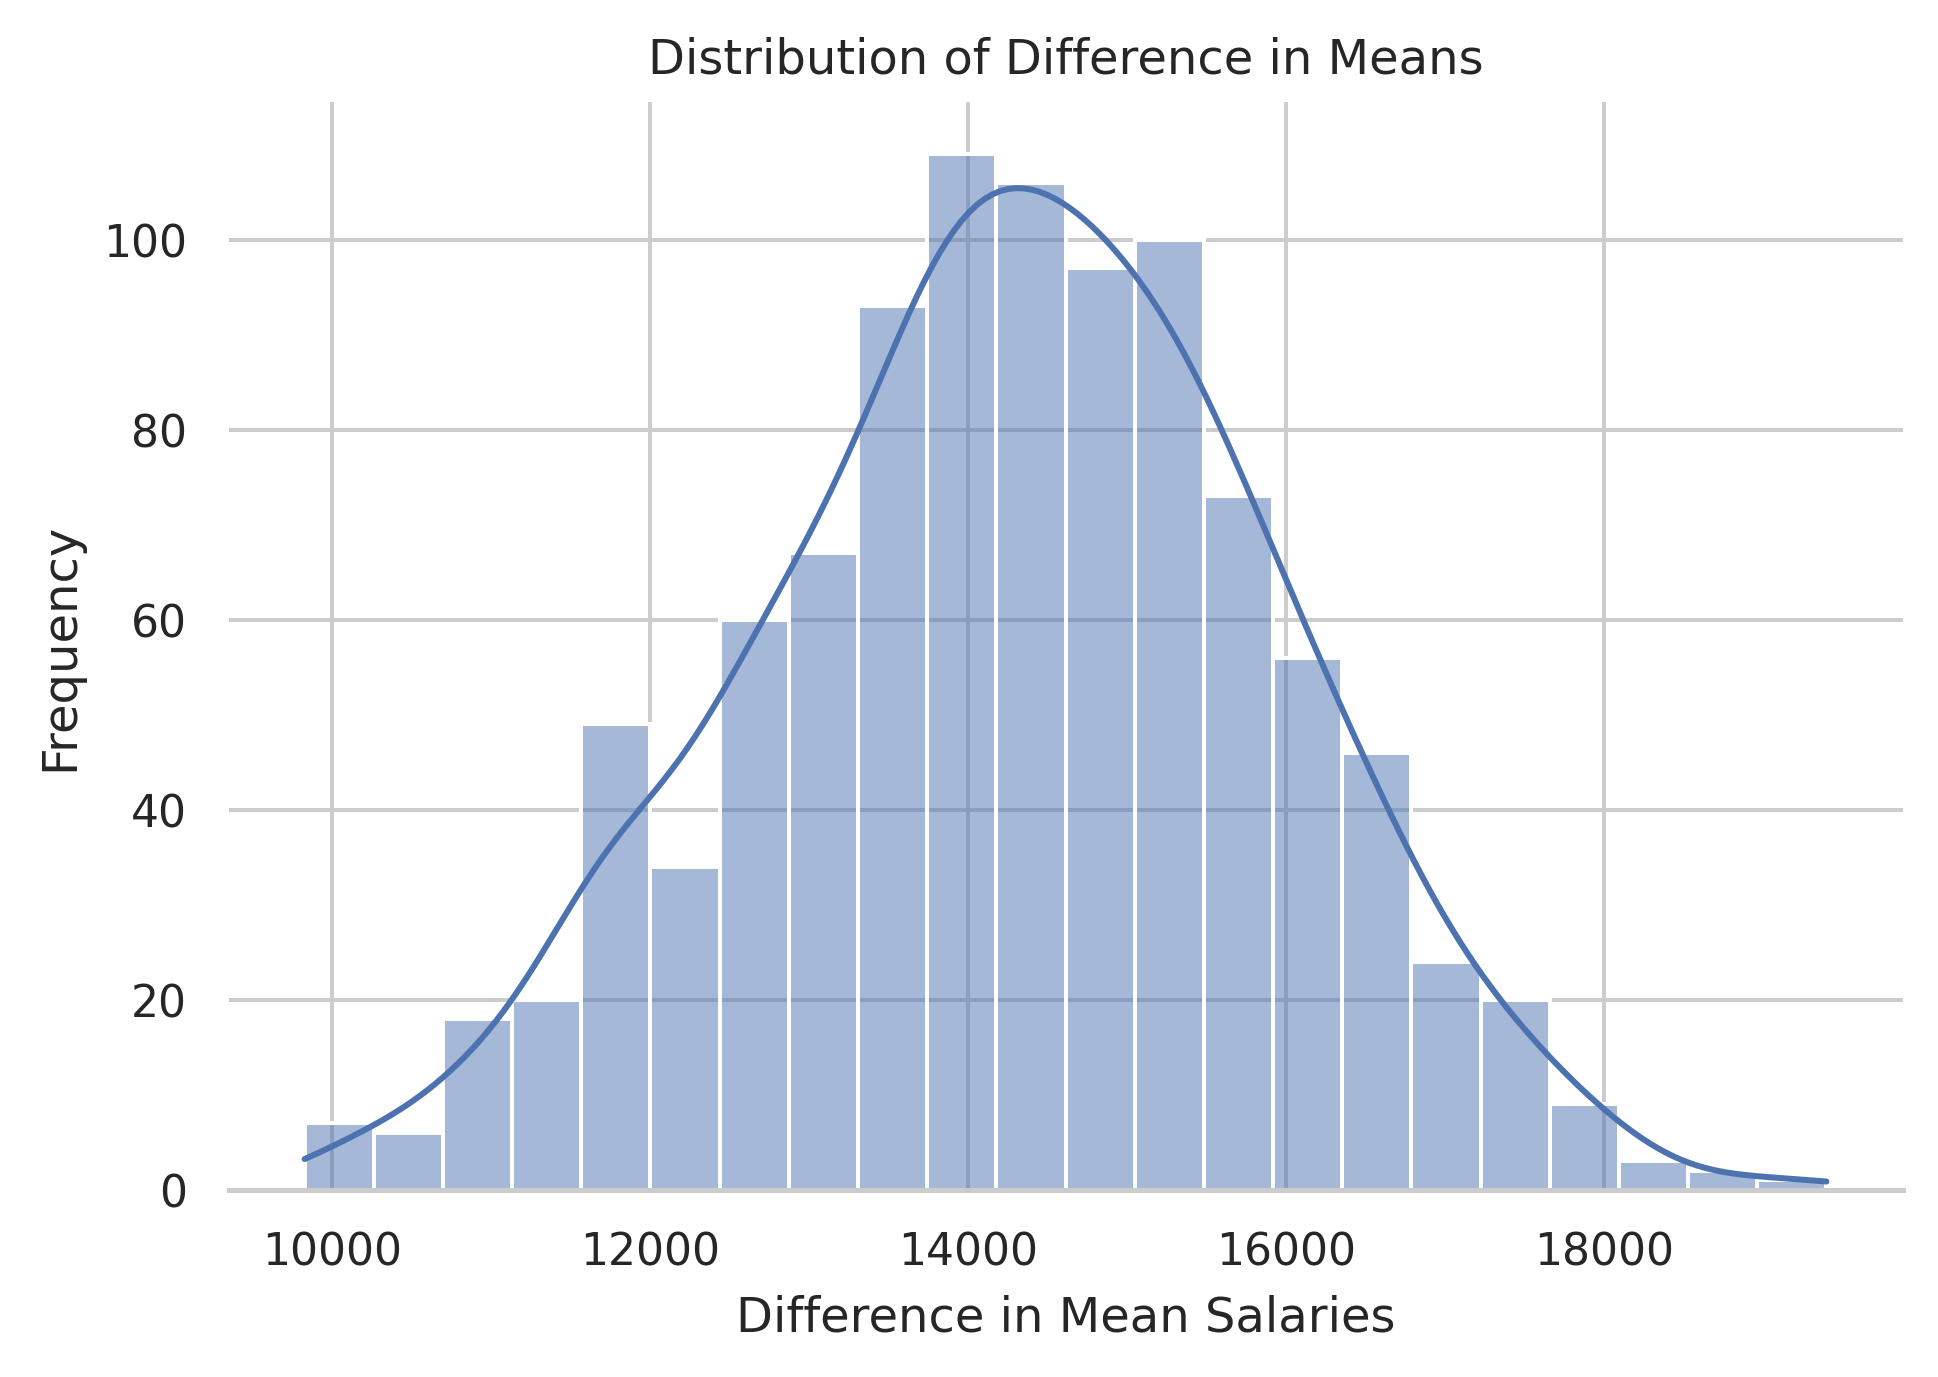

In [ ]:
# Distribution of difference in means
sns.set_theme(style="whitegrid")
sns.set_context("paper")
plt.rcParams['figure.dpi'] = 360
ax = sns.histplot(gender_diff, kde=True)
ax.set(xlabel='Difference in Mean Salaries', ylabel='Frequency', title='Distribution of Difference in Means')
sns.despine(left=True)

### 2d. Two-sample t-test on bootstrapped data

In [ ]:
# Test for normality
norm_test(bs_man) # bootstrapped man's salary mean distribution
norm_test(bs_woman) # bootstrapped woman's salarys mean distribution
norm_test(gender_diff) # differernce in mean distributions

Failed to reject null hypothesis, distribution is normal.
Failed to reject null hypothesis, distribution is normal.
Failed to reject null hypothesis, distribution is normal.


Based on the Central Limit Theorem (CLT), the above normality test results, and the plots from 2c, we can say that both distributions for the bootstrapped mean data are normal.

In [ ]:
# Use Levene's test for the two gender populations
levene_test(bs_man, bs_woman)

Statistically significant, the groups have different variances.


Although the Levene's test states that the two groups have different variances, we can proceed with Welch's t-test.

In [ ]:
# Perform two-sample t-test between the two bootstrapped mean distributions
stats.ttest_ind(bs_man, bs_woman, equal_var=False) # Welch's t-test which does not assume equal population variance

Ttest_indResult(statistic=281.9430476553381, pvalue=0.0)

With a p-value of 0.0 which is smaller than the 0.05 threshold, it is safe to determine that the difference between mean salaries for man and woman is statistically significant. 

### 2e. Findings

Looking at the original data, the salary distributions for both men and women do not meet the normality assumption, while the variances of both distributions are also different. Thus, it is not recommanded to perform two-sample t-test on the original data.

However, after bootstrapping (size 1000 with replacement) on both gender groups, the resulting mean distributions are both normal. Although Levene's test says that the two groups have different variances, we can proceed with the Welch's t-test ("equal_var=False", does not assume equal variances). The t-test result indicates that there is a significant difference between men and women salary distributions.

From the previous plots, we can conclude that the average salary for men is significantly higher than that for women.

Two-sample t-test is computationally light-weight, and easy to interpret. However, the independence, normality, and homoscedasticity assumptions need to be satisfied beforehand. Sampling method is also critical in this case, since convenience sampling or non-random allocation would render the test meaningless. The t-test should not be used for comparing more than two groups, otherwise Type I error would increase drastically.

## 3. Estimating the difference between average salary (Q24) of Bachelor's degree, Master's degree, and Doctoral degree (Q4) participants using ANOVA

### 3a. Compute and report descriptive statistics for each group

In [ ]:
# Create salary dataframes for two gender groups
bach = df_clean['Education'] == 'Bachelor’s degree'
ms = df_clean['Education'] == 'Master’s degree'
doc = df_clean['Education'] == "Doctoral degree"
df_bach = df_clean[bach][['Salary']]
df_ms = df_clean[ms][['Salary']]
df_doc = df_clean[doc][['Salary']]

In [ ]:
# Compute descriptive statistics for salaries
data = {"Bachelor's": df_bach.describe().to_numpy().flatten(), "Master's": 
        df_ms.describe().to_numpy().flatten(), "Doctoral": df_doc.describe().to_numpy().flatten()}
desc_stats = pd.DataFrame(data, index=df_bach.describe().index)
desc_stats

,Bachelor's,Master's,Doctoral
count,3013.000000,4878.000000,1718.000000
mean,35732.824427,52105.166052,68719.441211
std,60247.753546,67680.463052,85403.650394
min,1000.000000,1000.000000,1000.000000
25%,1000.000000,4000.000000,5000.000000
50%,10000.000000,25000.000000,40000.000000
75%,50000.000000,70000.000000,90000.000000
max,500000.000000,500000.000000,500000.000000


### 3b. Suitability of ANOVA with original data

In [ ]:
# Check normality
norm_test(df_bach)
norm_test(df_ms)
norm_test(df_doc)

Reject null hypothesis, distribution is not normal.
Reject null hypothesis, distribution is not normal.
Reject null hypothesis, distribution is not normal.


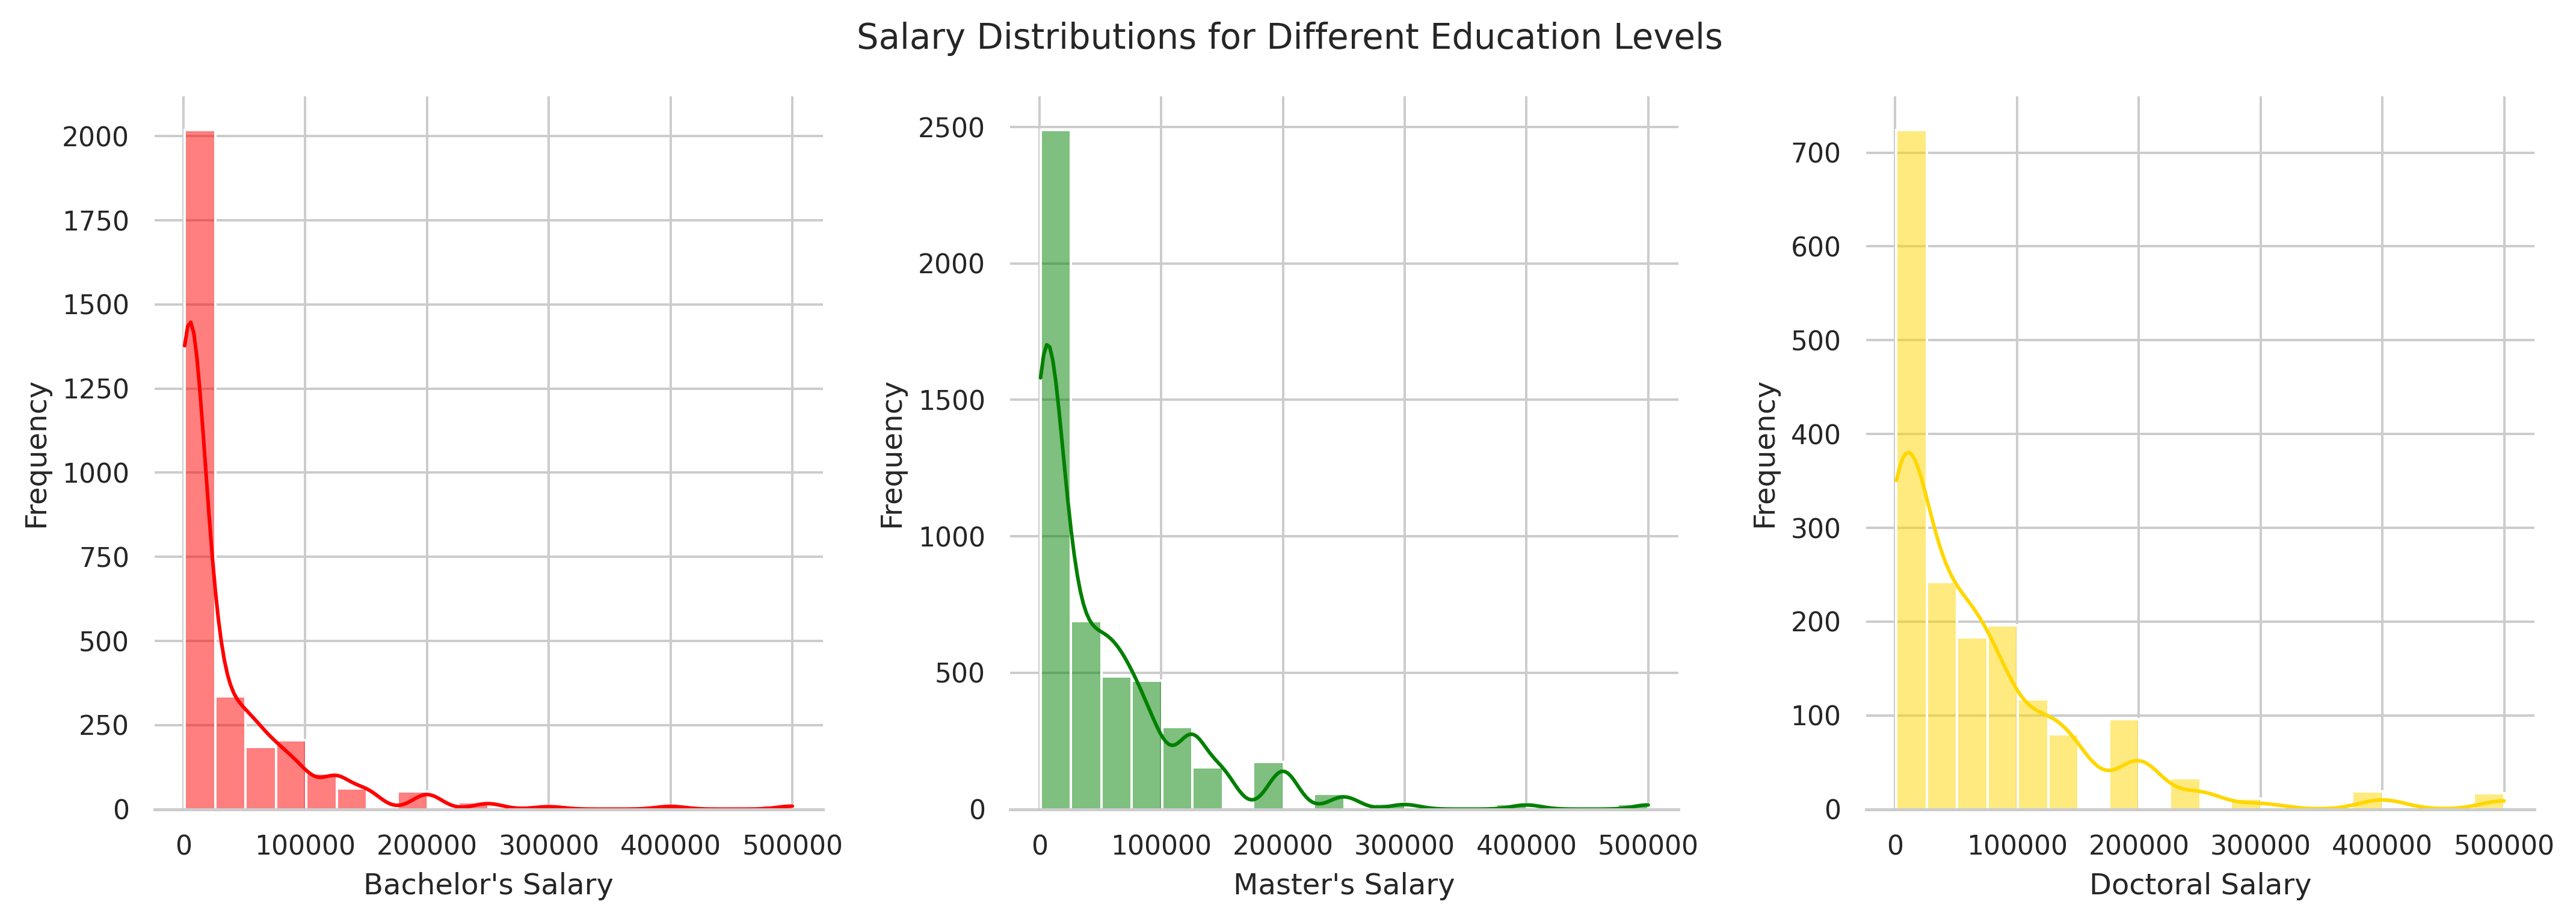

In [ ]:
# Original distributions
sns.set_theme(style="whitegrid")
sns.set_context("paper")
plt.rcParams['figure.dpi'] = 360
f, axes = plt.subplots(1, 3, figsize=(12, 4))
ax1 = sns.histplot(df_bach.Salary, color="red", ax=axes[0], kde=True, bins=20)
ax2 = sns.histplot(df_ms.Salary, color="green", ax=axes[1], kde=True, bins=20)
ax3 = sns.histplot(df_doc.Salary, color="gold", ax=axes[2], kde=True, bins=20)
plt.suptitle('Salary Distributions for Different Education Levels', y=1.05)
plt.tight_layout()
ax1.set(xlabel="Bachelor's Salary", ylabel='Frequency')
ax2.set(xlabel="Master's Salary", ylabel='Frequency')
ax3.set(xlabel="Doctoral Salary", ylabel='Frequency')
sns.despine(left=True)

In [ ]:
# Perform Levene's test for homoscedasticity
alpha = 0.05
_, p_value = stats.levene(df_bach.Salary, df_ms.Salary, df_doc.Salary, center='mean')
if p_value < alpha:
    print('Statistically significant, the groups have different variances.')
else:
    print('Failed to reject null hypothesis, the groups have similar variances.')

Statistically significant, the groups have different variances.


Since the original data does not satisfy the normality assumption and the equal variances assumption, it is not recommended to perform ANOVA using the original data.

### 3c. Bootstrapping for comparing difference in means of 3 education levels

In [ ]:
# Bootstrapping function
def bootstrap_3(population_dist1, population_dist2, population_dist3):
    bootstrap_mean1 = []
    bootstrap_mean2 = []
    bootstrap_mean3 = []
    mean_diff12 = []
    mean_diff13 = []
    mean_diff23 = []

    # 1000 replications with replacement
    for i in range(1000):
        # Bootstrap sampling with same size as the original distribution
        sample_mean1 = population_dist1.sample(frac=1, replace=True)
        sample_mean2 = population_dist2.sample(frac=1, replace=True)
        sample_mean3 = population_dist3.sample(frac=1, replace=True)
        # Compute mean of each bootstrap sample
        bootstrap_mean1.append(sample_mean1.mean())
        bootstrap_mean2.append(sample_mean2.mean())
        bootstrap_mean3.append(sample_mean3.mean())
    
    bootstrap_mean1 = np.asarray(bootstrap_mean1).flatten()
    bootstrap_mean2 = np.asarray(bootstrap_mean2).flatten()
    bootstrap_mean3 = np.asarray(bootstrap_mean3).flatten()

    # Compute difference in means
    mean_diff12 = bootstrap_mean1 - bootstrap_mean2
    mean_diff13 = bootstrap_mean1 - bootstrap_mean3
    mean_diff23 = bootstrap_mean2 - bootstrap_mean3

    return bootstrap_mean1, bootstrap_mean2, bootstrap_mean3, mean_diff12, mean_diff13, mean_diff23

In [ ]:
# Bootstrapping and compute differences in means between 3 groups
bs_bach, bs_ms, bs_doc, diff_bm, diff_bd, diff_md = bootstrap_3(df_bach, df_ms, df_doc)

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


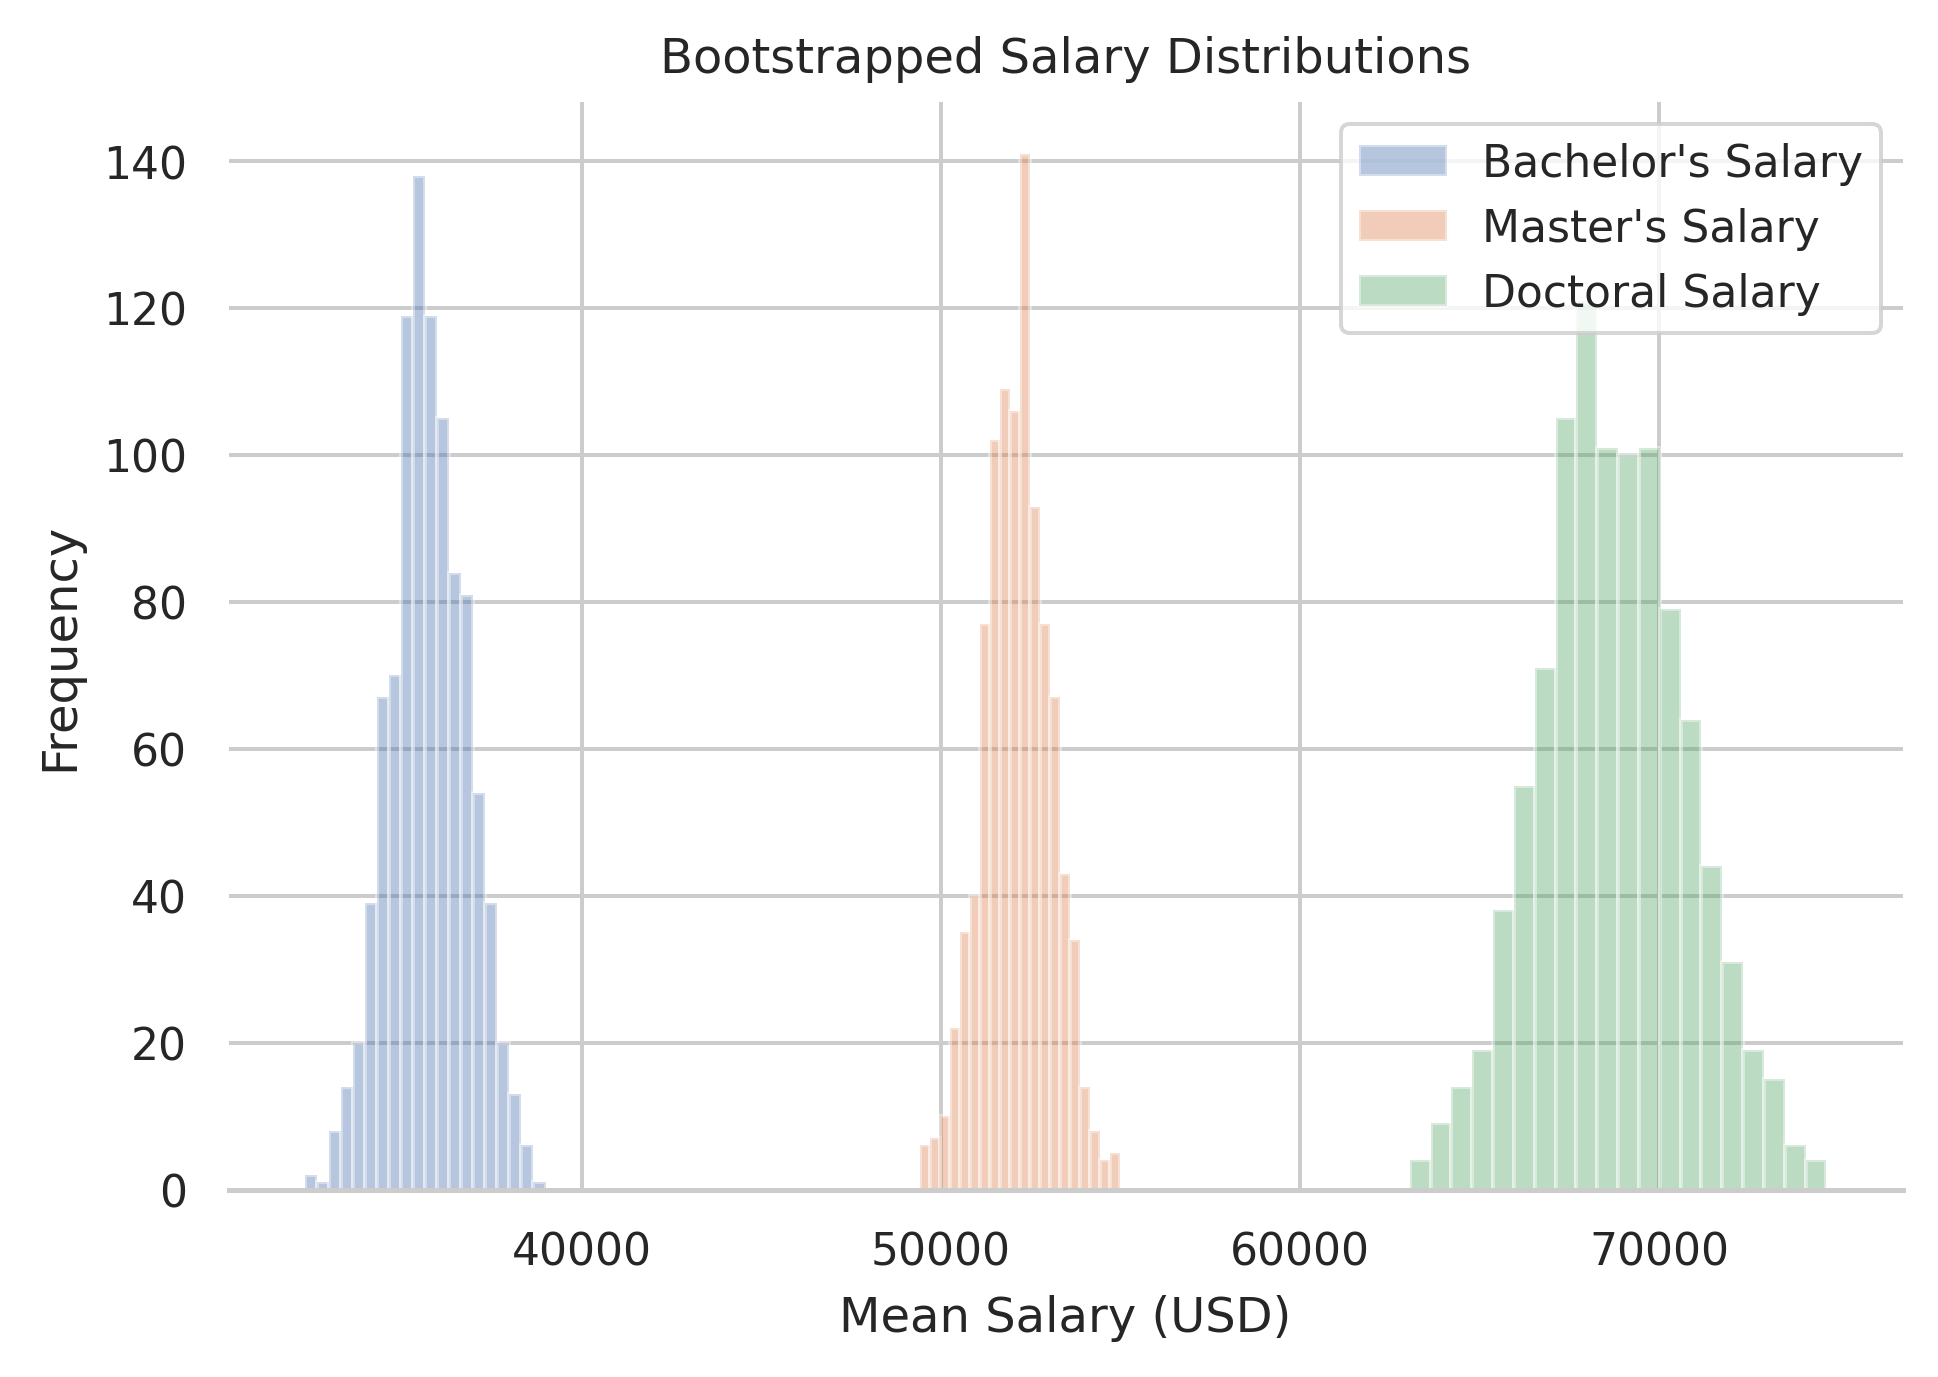

In [ ]:
# Salary distributions after bootstrapping
sns.set_theme(style="whitegrid")
sns.set_context("paper")
plt.rcParams['figure.dpi'] = 360
fig, ax = plt.subplots()
for a in [bs_bach, bs_ms, bs_doc]:
    sns.distplot(a, bins=20, ax=ax, kde=False)
ax.set(xlabel='Mean Salary (USD)', ylabel='Frequency', title='Bootstrapped Salary Distributions')
plt.legend(labels=["Bachelor's Salary","Master's Salary", "Doctoral Salary"])
sns.despine(left=True)

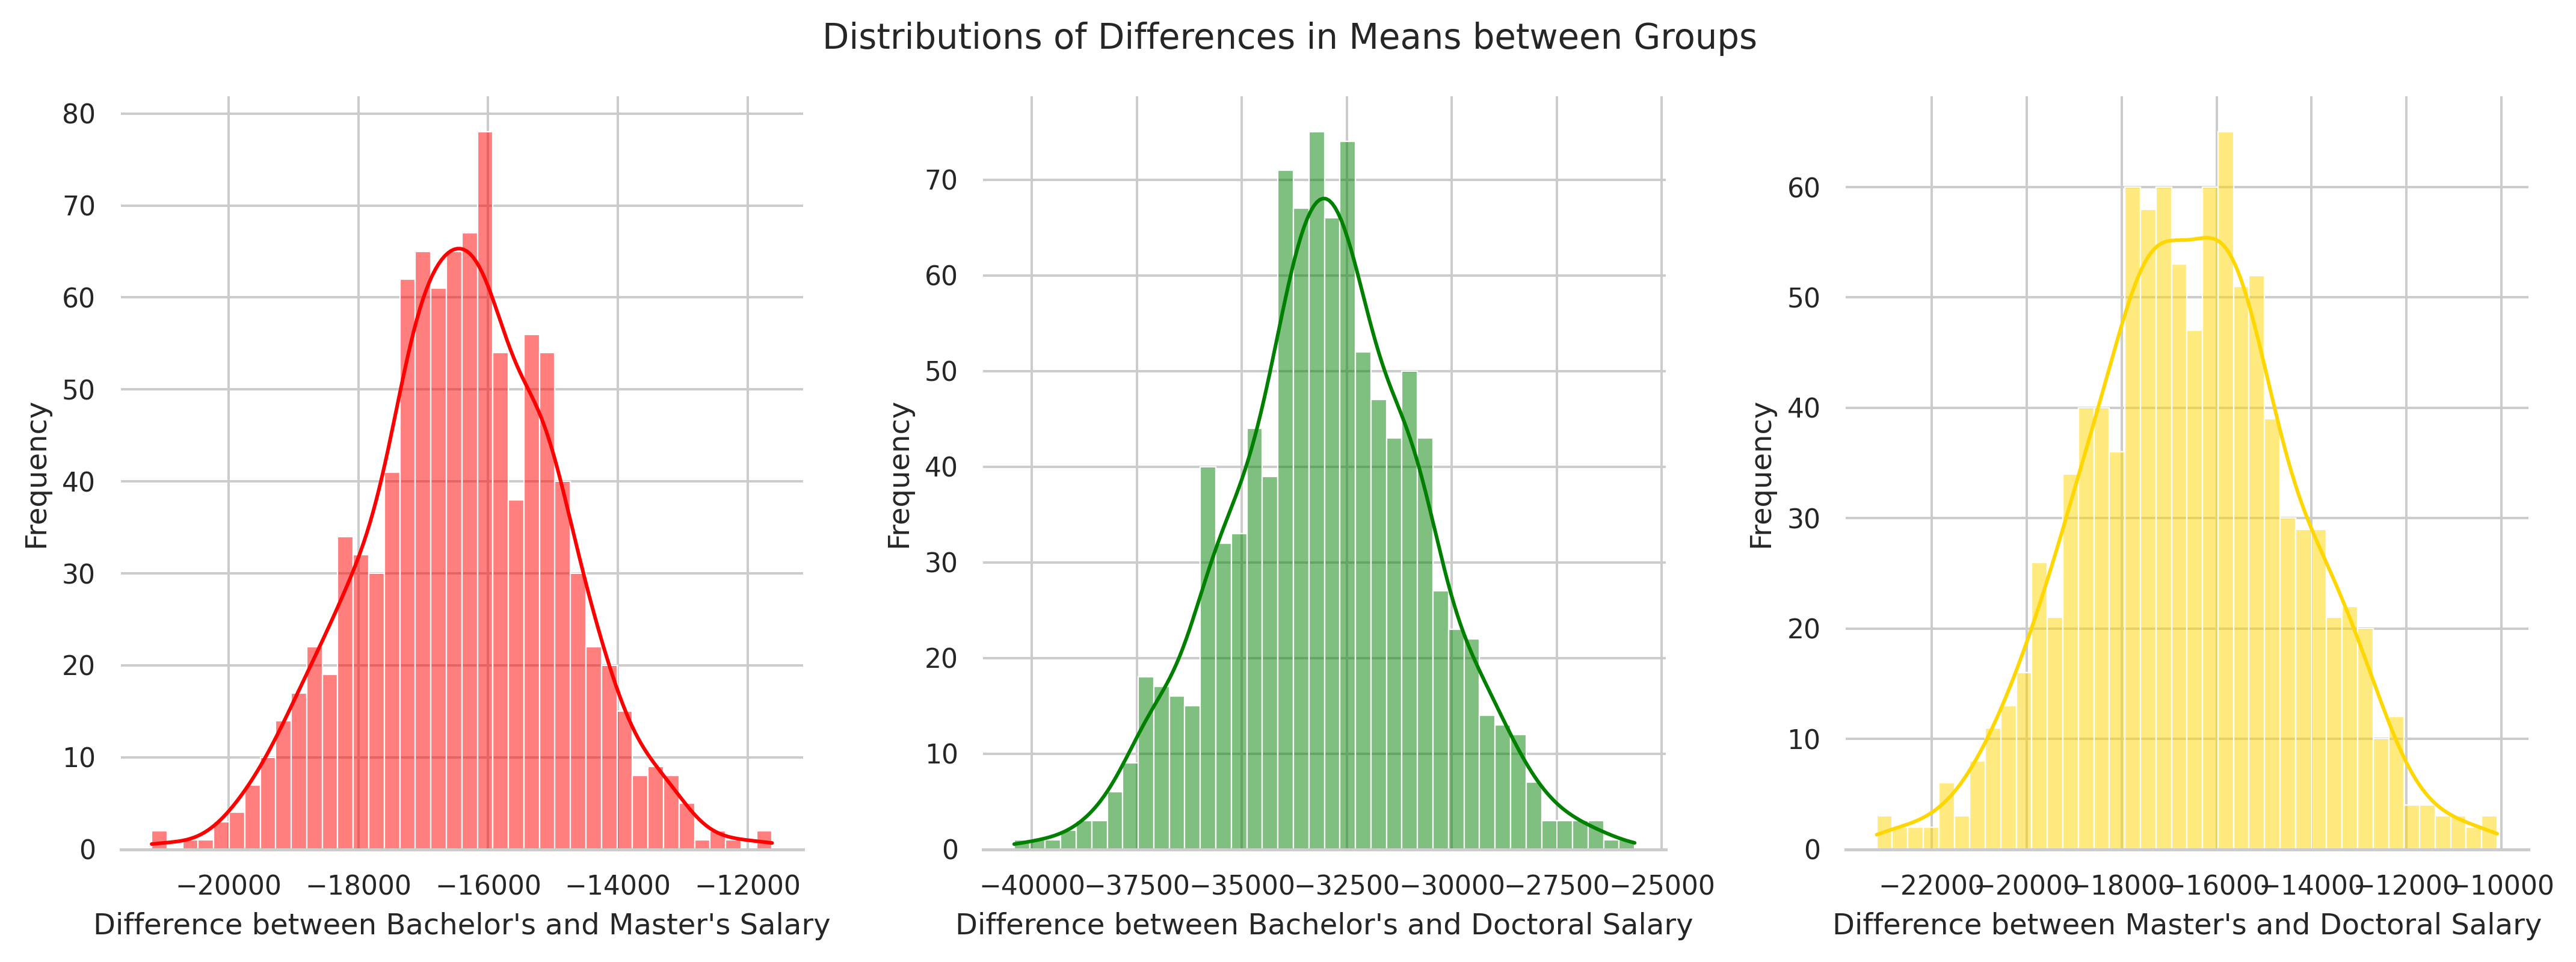

In [ ]:
# Distributions of differences between groups
sns.set_theme(style="whitegrid")
sns.set_context("paper")
plt.rcParams['figure.dpi'] = 360
f, axes = plt.subplots(1, 3, figsize=(12, 4))
ax1 = sns.histplot(diff_bm, color="red", ax=axes[0], bins=40, kde=True)
ax2 = sns.histplot(diff_bd, color="green", ax=axes[1], bins=40, kde=True)
ax3 = sns.histplot(diff_md, color="gold", ax=axes[2], bins=40, kde=True)
plt.suptitle('Distributions of Differences in Means between Groups', y=1.05)
plt.tight_layout()
ax1.set(xlabel="Difference between Bachelor's and Master's Salary", ylabel='Frequency')
ax2.set(xlabel="Difference between Bachelor's and Doctoral Salary", ylabel='Frequency')
ax3.set(xlabel="Difference between Master's and Doctoral Salary", ylabel='Frequency')
sns.despine(left=True)

### 3d. ANOVA on bootstrapped data

In [ ]:
# Test for normality
norm_test(bs_bach)
norm_test(bs_ms)
norm_test(bs_doc)
norm_test(diff_bm)
norm_test(diff_bd)
norm_test(diff_md)

Failed to reject null hypothesis, distribution is normal.
Failed to reject null hypothesis, distribution is normal.
Failed to reject null hypothesis, distribution is normal.
Failed to reject null hypothesis, distribution is normal.
Failed to reject null hypothesis, distribution is normal.
Failed to reject null hypothesis, distribution is normal.


In [ ]:
# Perform Levene's test for homoscedasticity after bootstrapping
alpha = 0.05
_, p_value = stats.levene(bs_bach, bs_ms, bs_doc, center='mean')
if p_value < alpha:
    print('Statistically significant, the groups have different variances.')
else:
    print('Failed to reject null hypothesis, the groups have similar variances.')

Statistically significant, the groups have different variances.


In [ ]:
# Compute the standard deviations for each bootstrap mean distribution
bs_bach_std = np.std(bs_bach)
bs_ms_std = np.std(bs_ms)
bs_doc_std = np.std(bs_doc)
print("Standard deviations for 3 bootstrapped mean distributions are:", 
      bs_bach_std, bs_ms_std, bs_doc_std)

Standard deviations for 3 bootstrapped mean distributions are: 1071.814875470144 941.7045262060012 2043.4265502301446


Although the Levene's test states that the 3 groups have different variances, since their standard deviations are actually not very far apart, we can proceed to perform parametric ANOVA.

In [ ]:
# Perform Welch's ANOVA on 3 bootstrapped mean distributions
stats.f_oneway(bs_bach, bs_ms, bs_doc)

F_onewayResult(statistic=131080.39926291318, pvalue=0.0)

With p-value = 0.0 which is smaller than the 0.05 threshold, we can determine that there is a statistically significant difference between the mean salary of the three groups with different education levels.

### 3e. Findings

Looking at the original data, the salary distributions for Bachelor's degree, Master's degree, and Doctoral degree do not meet the normality assumption, while the variances of the three distributions are different. Thus, it is not recommanded to perform ANOVA on the original data.

However, after bootstrapping (size 1000 with replacement) on the three groups, the resulting mean distributions all seem to be normal. The between-group mean differences also follow normal distributions. On average:
- Bachelor's participant's salary is about 17000 less than Master's participants;
- Bachelor's participant's salary is about 33000 less than Doctoral participants;
- Master's participant's salary is about 17000 less than Doctoral participants.

Although Levene's test says that the three groups have different variances, since the standard deviations for the three bootstrapped mean distributions are actually not far apart (1071.8, 941.7, and 2043.4), we can proceed with the parametric ANOVA test. The ANOVA result indicates that there is a significant difference between the average salaries of Bachelor's, Master's, and Doctoral participants.

ANOVA has a robust design and can increase statistical power, but it does come with assumptions similar to the two-sample t-test. Also, even if null hypothesis is rejected when p-value is less than 0.05, we only know that differences exist between the groups, but we would need post-hoc tests or planned comparisons to see which group(s) significantly differ from each other.